Based on https://github.com/James-Jagielski/7-bit-D-A-converter-MP4-MADVLSI/blob/main/schematics/simulations/plot_dac_mc.ipynb with permission of repo owners

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from si_prefix import si_format

In [13]:
n_bits = 7
mc_simulations = []
nano = 1e-9
results_dir = "./mc"
ideal_step_size = 3.8e-06/(2**7)

       net3    net3.1    net3.2    net3.3    net3.4    net3.5    net3.6  \
0  0.192450  0.192450  0.192450  0.192450  0.192450  0.192450  0.192450   
1  0.192444  0.192444  0.192444  0.192444  0.192444  0.192444  0.192444   
2  0.192443  0.192443  0.192443  0.192443  0.192443  0.192443  0.192443   
3  0.192440  0.192440  0.192440  0.192440  0.192440  0.192440  0.192440   
4  0.192441  0.192441  0.192441  0.192441  0.192441  0.192441  0.192441   
5  0.192437  0.192437  0.192437  0.192437  0.192437  0.192437  0.192437   
6  0.192437  0.192437  0.192437  0.192437  0.192437  0.192437  0.192437   
7  0.192435  0.192435  0.192435  0.192435  0.192435  0.192435  0.192435   
8  0.192437  0.192437  0.192437  0.192437  0.192437  0.192437  0.192437   
9  0.192433  0.192433  0.192433  0.192433  0.192433  0.192433  0.192433   

     net3.7  i(v_i_in)    net3.8      Iout   code  
0  0.192450    0.00001  0.192450  0.000002    0.0  
1  0.192444    0.00001  0.192444  0.000002   64.0  
2  0.192443    0.0

KeyError: 'Iout'

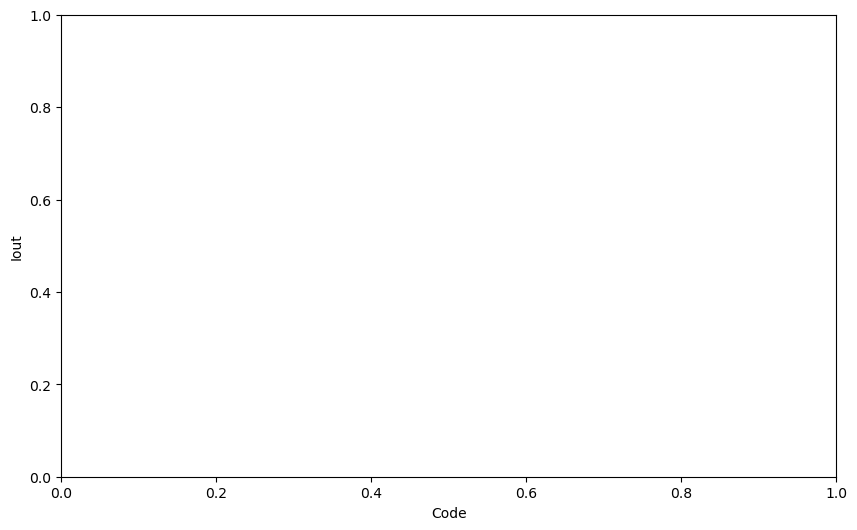

In [20]:
for filename in os.listdir(results_dir):
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    # print(df.head(3))
    #print(df)
    df["code"] = df["v(b0)"] * 0 # init column to all 0s
    for bit in range(n_bits):
        # df["code"] = df["code"] + (df[f"v{bit}"] > .5*df["vdd"]) * 2 ** (n_bits - bit - 1)
        df["code"] = df["code"] + (df[f"v(b{bit})"] > .5*1.8) * 2 ** (n_bits - bit - 1)
        df.drop(f"v(b{bit})", axis = "columns", inplace = True)
    df.rename({"i(vi_out)": "Iout"}, axis = "columns", inplace = True)
    print(df.head(10))

    mc_simulations.append(df)
tdf = pd.concat(mc_simulations)
plt.figure(figsize = (10, 6))
plt.xlabel("Code")
plt.ylabel("Iout")

#z = np.polyfit(tdf["code"], tdf["Iout"], 1)
z = [ideal_step_size,0]
print(z)
p = np.poly1d(z)

errors = np.subtract(p(tdf["code"]),tdf["Iout"])

print("max allowable error", np.mean( np.subtract( p(range(1,128)) ,p(range(0,127)) ) )/2 )
print("max error",np.max(errors))
print("variance of error",np.max(errors))

dnl  = []
dnl_multi = []
for df_simulation in mc_simulations:
    sorted = df_simulation.sort_values("code")
    current =   np.subtract(np.divide(
                    np.subtract(
                         list(sorted["Iout"])[1:],list(sorted["Iout"])[:-1]
                    ),ideal_step_size),1)
    #print(current)
    cc = list(current) #list(np.vstack((current,dnl)).T)
    #print(len(cc))
    dnl_multi.append(cc)
    for line in cc:
        dnl.append(line)#dnl.append(float(max(line,key=abs)))
    #print(dnl)

inl = np.sum(dnl)



# plt.plot(range(128),p(range(128)),"k--", label = "trendline", linewidth = .5)

for i, df_simulation in enumerate(mc_simulations):
    # plt.plot(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), linewidth = 1, label = f"Run {i}")
    plt.scatter(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), s = 2, label = f"Run {i}")
plt.legend(loc = "lower right")

plt.figure()
plt.plot(range(len(dnl)), dnl)
plt.title("DNL values")
print("max overall dnl",max(dnl,key=abs)) 
print("loc of max value",dnl.index(max(dnl,key=abs)))
print("INL" , inl)
plt.ylabel("lsbs of error")